# Customer segmentation

Here I categorise customers according to their purchase pattern and product purchaces.
I will use the following information to categorise the customers:
 1. RFM-based metrics of cutomer behaviour: I will use the intormation on total number of orders (frequency), the money brought by the customer (monetary), and the time of the most recent purchache (recency).
 2. Geographical information of the cutomer
 3. Type of items bought by the customer

## Customer-based dataset

I start from the cleaned dataset that contains purchaces of knonw goods.

In [1]:
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import pickle
import geopandas as gpd
from IPython.display import Image
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.cm as cm
from pprint import pprint

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.facecolor' : 'white',
         'figure.facecolor' : 'white',          
         'axes.grid' : False}
pylab.rcParams.update(params)


In [2]:
sales_data = pd.read_hdf("for_categorisation_sales.hdf")

Here I add geographical information. For categorisaion, I am interested in the region of the customer.

In [3]:
countries = sales_data['Country'].unique()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [4]:
known_world=world[world.name.isin(countries)][['continent','name']].set_index('name').to_dict()['continent']
known_world['EIRE'] = 'Europe'
known_world['Channel Islands'] = 'Europe'
known_world['USA'] = 'North America'
known_world['Unspecified'] = 'UK'
known_world['Malta'] = 'Europe'
known_world['RSA'] = 'Africa'
known_world['Singapore'] = 'Asia'
known_world['Bahrain'] = 'Asia'
known_world['West Indies'] = 'South America'
known_world['Korea'] = 'Asia'
known_world['Czech Republic'] = 'Europe'
known_world['European Community'] = 'Europe'
known_world['United Kingdom'] = 'UK'

In [5]:
# Region is really the only relevant categorical data I have.
# This brings troubles with clustering algorithms.
# Good news that it is possible to tranform the region to the numerical value:
# UK: 0
# Europe : 1
# Rest: 10
# This is numerical way to say where is the customer: in UK, nearby, or very far away.
region_map = {'UK':0, 'Europe':1, 'Asia':10,'Oceania':10,'North America':10, 'South America':10, 'Africa':10}

In [6]:
# Applying name of the region based on the country
sales_data['Region'] = sales_data['Country'].apply(lambda x: known_world[x])
# Applying the "region score"
sales_data['Region'] = sales_data['Region'].apply(lambda x: region_map[x])

Now, let's build temoprary invoice-based dataframe where we merge individual items to the corresponding invoices

In [7]:
# Note that this is the only place I have explicity written names of the product categories
# If one changes the catgories of data, this will be the only line to change.
product_categories = ['Product_0', 'Product_1', 'Product_2','Product_3','Product_4']
# Grouping the dataset
invoice_data = sales_data[['Invoice','Quantity','Amount']+product_categories].groupby("Invoice").sum()
invoice_data['cID'] = sales_data[['Invoice','cID']].groupby("Invoice").first()
invoice_data['InvoiceDate'] = sales_data[['Invoice','InvoiceDate']].groupby("Invoice").first()
invoice_data['Country'] = sales_data[['Invoice','Country']].groupby("Invoice").first()
invoice_data['Region'] = sales_data[['Invoice','Region']].groupby("Invoice").first()
invoice_data = invoice_data.query("Amount > 0")

In [8]:
# The last entry of the database - we will compute recency relatively to it.
last_day =  invoice_data['InvoiceDate'].max().date()

In [9]:
# Recency - time passed since last buy
invoice_data['Recency'] = (last_day - invoice_data['InvoiceDate'].dt.date).dt.days.astype(int)

Now, we need to merge invoices coming from the same customer on same day. This is needed since we will use frequencey, and two invoices coming the same day most likely could be one if customers would be more careful during the buying process, for example.

In [10]:
invoice_data['InvoiceDate'] = invoice_data['InvoiceDate'].dt.date

In [11]:
tmp_invoice_data = invoice_data.reset_index()[['Quantity','Amount','InvoiceDate','cID']+\
                                              product_categories].groupby(['cID','InvoiceDate']).sum()

In [12]:
tmp_invoice_data['Country'] = invoice_data.reset_index()[['Country','InvoiceDate','cID']]\
                                .groupby(['cID','InvoiceDate']).first()
tmp_invoice_data['Region'] = invoice_data.reset_index()[['Region','InvoiceDate','cID']]\
                                .groupby(['cID','InvoiceDate']).first()
tmp_invoice_data['Recency'] = invoice_data.reset_index()[['Recency','InvoiceDate','cID']]\
                                .groupby(['cID','InvoiceDate']).first()
tmp_invoice_data['Invoice'] = invoice_data.reset_index()[['InvoiceDate','Invoice','cID']]\
                                .groupby(['cID','InvoiceDate']).first()
tmp_invoice_data['InvoicePrice'] = tmp_invoice_data['Amount']/tmp_invoice_data['Quantity'] #Average price of the item in invoice


In [13]:
invoice_data = tmp_invoice_data.reset_index(["cID","InvoiceDate"]).set_index("Invoice")

Now, let's combine those invoices to fill up the customer information

In [14]:
customer_data = invoice_data[['cID','Amount','Quantity']+product_categories].groupby('cID').sum()
customer_data["Country"] = invoice_data[['cID','Country']].groupby('cID').first()
customer_data["Region"] = invoice_data[['cID','Region']].groupby('cID').first()
customer_data["Frequency"] = invoice_data.reset_index()[['cID','Invoice']].groupby('cID').count()
customer_data["Recency_Min"] = invoice_data[['cID','Recency']].groupby('cID').min()
customer_data["Recency_Max"] = invoice_data[['cID','Recency']].groupby('cID').max()

Some metrics to judge about customer behaviour:

In [15]:
# Average time interval between orders
customer_data["Average_Interval"] = ((customer_data["Recency_Max"]-customer_data["Recency_Min"]))/(customer_data["Frequency"]-1)
# Assign mean value for one-time buyers
customer_data["Average_Interval"] = customer_data["Average_Interval"].fillna(customer_data["Average_Interval"].mean())
# Time since last buy relative to the average time betwen acquisitions 
customer_data['Pending_Time'] = customer_data["Recency_Min"]/customer_data["Average_Interval"]
# Average amount spent per invoice
customer_data["Average_Cheque"] = customer_data["Amount"]/customer_data["Frequency"]
# Average price of the item bought by customer (We will use it for visualisation only)
customer_data["Average_Price"] = invoice_data[['cID','InvoicePrice']].groupby('cID').mean()

Later of we will need to study churring of user. `PendingTime` is a good variable for this, but to better understand what are the critical values of the pending times, let's also count the maximal intervals and between buys for customer (and maximal pending values that existed in between the buys)

In [16]:
def get_max_pending(dates):
    if len(dates)<2:
        return np.nan
    dates = dates.values
    dates = sorted(dates)
    first_date = dates[0]
    interval = (dates[1]-dates[0]).days
    average_interval = customer_data["Average_Interval"].mean()
    pending = interval/average_interval
    for i, d in enumerate(dates[2:]):
        i_i = dates[i+2] - dates[i+1]
        average_interval = (dates[i+2]-dates[0])/(i+1)
        i_pending = i_i/average_interval
        if i_pending > pending:
            pending = i_pending
    return pending

def get_max_interval(dates):
    if len(dates)<2:
        return np.nan
    dates = dates.values
    dates = sorted(dates)
    interval = dates[1]-dates[0]
    for i, d in enumerate(dates[2:]):
        i_i = dates[i+2] - dates[i+1]
        if i_i > interval:
            interval = i_i
    return interval.days



customer_data["MaxInterval"] = invoice_data[['cID','InvoiceDate']].groupby('cID').agg(get_max_interval)
customer_data["MaxPending"] = invoice_data[['cID','InvoiceDate']].groupby('cID').agg(get_max_pending)

Finally, let's make a "shopping profile" of the customer - that is let's define how does the the item they buy split into our product categories:

In [17]:
for p in product_categories:
    customer_data[p]=customer_data[p]/customer_data['Quantity']

In [18]:
# Excellent. Let's look at our dataset now.
customer_data.describe()

,Amount,Quantity,Product_0,Product_1,Product_2,Product_3,Product_4,Region,Frequency,Recency_Min,Recency_Max,Average_Interval,Pending_Time,Average_Cheque,Average_Price,MaxInterval,MaxPending
count,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,5851.000000,4175.000000,4175.000000
mean,2882.074767,1776.792685,0.180149,0.182309,0.481420,0.141750,0.014372,0.192104,5.606050,199.797983,473.337207,111.687108,3.504186,396.163183,2.526335,177.697006,1.661808
std,14204.227985,8743.971116,0.197197,0.154859,0.213297,0.161206,0.068305,1.096075,9.899365,208.545299,223.263827,86.558682,18.050941,573.860125,9.475118,121.419686,1.083491
min,2.900000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.900000,0.136300,1.000000,0.008954
25%,341.950000,191.000000,0.000000,0.071540,0.353127,0.050465,0.000000,0.000000,1.000000,25.000000,311.000000,57.316667,0.295468,185.885312,1.511876,84.000000,0.908721
50%,871.940000,488.000000,0.127572,0.162162,0.481818,0.098443,0.002377,0.000000,3.000000,95.000000,529.000000,111.687108,0.994505,295.045000,1.960476,154.000000,1.441527
75%,2252.515000,1365.500000,0.283775,0.253122,0.609272,0.171545,0.010069,0.000000,6.000000,379.000000,666.000000,111.687108,3.626089,438.674457,2.562349,247.000000,2.144009
max,607604.450000,364389.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,247.000000,738.000000,738.000000,714.000000,736.000000,17545.150000,649.500000,714.000000,14.244618


## Recency-Frequency-Monetary analysis
Here I split customers into the RFM quartiles

In [19]:
# Quartile borders
quantiles = customer_data[['Frequency','Recency_Min','Amount']].quantile(q=[0.25,0.5,0.75],)
quantiles = quantiles.to_dict()

In [20]:
def RScore(x,p,d):
    # Recency scoring: minimal recency gives highest score
    if x <= d[p][0.25]:
        return 1
    if x <= d[p][0.50]:
        return 2
    if x <= d[p][0.75]: 
        return 3
    return 4
    
def FMScore(x,p,d):
    # Frequency amd Monetary scoring: higher FM values give highest scores
    if x <= d[p][0.25]:
        return 4
    if x <= d[p][0.50]:
        return 3
    if x <= d[p][0.75]: 
        return 2
    return 1

# Adding RFM scores
customer_data['r_quartile'] = customer_data['Recency_Min'].apply(RScore, args=('Recency_Min',quantiles,))
customer_data['f_quartile'] = customer_data['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
customer_data['m_quartile'] = customer_data['Amount'].apply(FMScore, args=('Amount',quantiles,))
customer_data['RFM'] = 100*customer_data['r_quartile']+10*customer_data['f_quartile']+customer_data['m_quartile']
customer_data.head()



,Amount,Quantity,Product_0,Product_1,Product_2,Product_3,Product_4,Country,Region,Frequency,...,Average_Interval,Pending_Time,Average_Cheque,Average_Price,MaxInterval,MaxPending,r_quartile,f_quartile,m_quartile,RFM
cID,,,,,,,,,,,,,,,,,,,,,
12346.0,169.36,24.0,0.000000,0.000000,0.000000,1.000000,0.000000,United Kingdom,0,2,...,118.000000,4.483051,84.680,6.450000,118.0,1.056523,4,3,4,434
12347.0,5633.32,3286.0,0.083384,0.293974,0.480219,0.136945,0.005478,Iceland,1,8,...,57.428571,0.034826,704.165,1.676006,90.0,1.232877,1,1,1,111
12348.0,1658.40,2704.0,0.576923,0.189349,0.233728,0.000000,0.000000,Finland,1,5,...,90.750000,0.826446,331.680,0.780028,173.0,1.429752,2,2,2,222
12349.0,3678.69,1621.0,0.154226,0.140654,0.543492,0.143122,0.018507,Italy,1,3,...,285.500000,0.063047,1226.230,2.265911,389.0,1.629552,1,3,1,131
12350.0,294.40,196.0,0.000000,0.234694,0.765306,0.000000,0.000000,Norway,1,1,...,111.687108,2.775611,294.400,1.502041,NaN,NaN,3,4,4,344


So customers are split to several RFM quantiles. Here is useful description of those customers and possible marketing strategies:

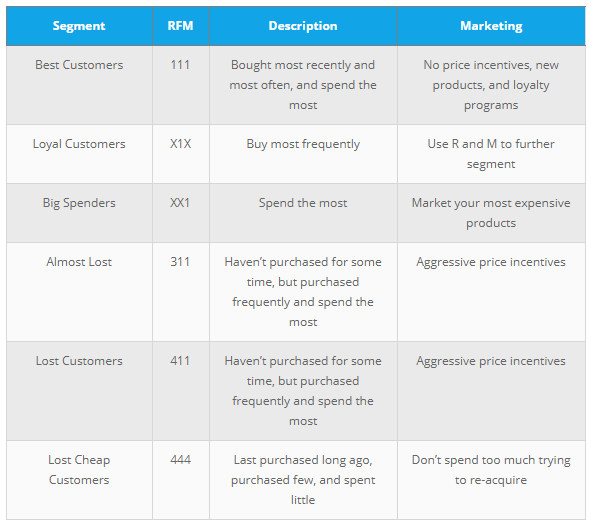

In [21]:
Image('YmItbbm.png')

Here is some visualisation showing how are those quartiles populated.

In [22]:
rfm_data = customer_data.reset_index()[['cID','RFM']].groupby('RFM').count()
rfm_data['r_quartile'] = customer_data[['r_quartile','RFM']].groupby("RFM").first()
rfm_data['f_quartile'] = customer_data[['f_quartile','RFM']].groupby("RFM").first()
rfm_data['m_quartile'] = customer_data[['m_quartile','RFM']].groupby("RFM").first()


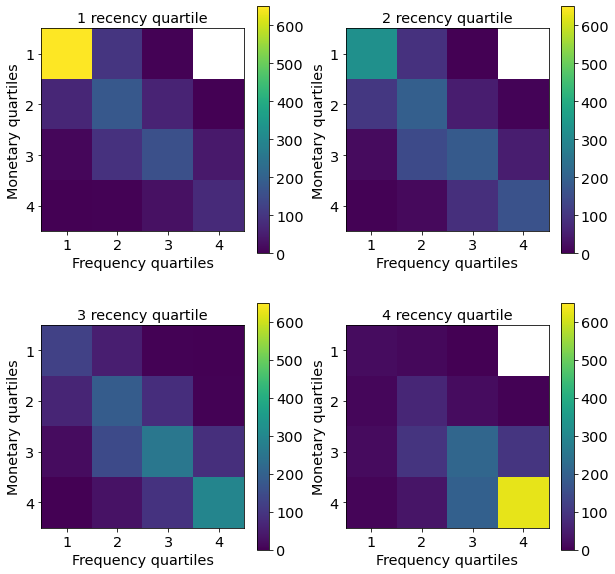

In [23]:
plt.figure()
for q in range(1,5):
    plt.subplot(2, 2, q)
    matrix = rfm_data.query("r_quartile == "+str(q)).groupby(["f_quartile","m_quartile"])['cID'].sum().unstack().to_numpy()
    plt.imshow(matrix,vmin = 0, vmax = 650)
    plt.colorbar()
    plt.xlabel("Frequency quartiles")
    plt.xticks(range(4),[1,2,3,4])
    plt.ylabel("Monetary quartiles")
    plt.yticks(range(4),[1,2,3,4])
    plt.title(str(q)+" recency quartile")


Most of the customers are in "good" RFM quantile - they did not churned, they buy regularly and spent lots of money.
Another big category are "Lost and cheap" customers - nothing to worry about.

# Customer categorisaton

Here I will clusterise customers in "data-driven" way. I will only use numerical data, so it is possible to use `KMeans` algorithm. I want to categorise customers using their behaviour, and I don't want to have too many correlated variables. In other words, I want each variable used by the algorithm to contain the maximum of the new information. This will help reducing dimensionaity and intrpretanility of the obtained results. From another hands, I want to have maningful variables insinde the dataset, that already bring an insight on the customers' behaviour. That's what I am using:
 * `Average_Cheque` - the average basket size of the customer. I expect to catch some "Big spenders" with this variable.
 * `Frequency` - the number of times customer bought something from the company. This metrics characterise the behaviour of the customer and his importance for the business.
 * `Recency_Max` - is the number of days since the first buy for the customer. Useful to detect the new customers  who would be lost into "bad" FM qurtiles otherise.
 * `Pending_Time` - is the time since the last buy relative to the expected time for the customer to do the next buy.
 * `Region` - as explained abover, this is the variable to group customers from faraway.
 * `Avererage_Interval` - the expected time for the customer to make the new buy.
 * `product_category` - fractions of items bough by the customers within each category. While I currently use product categories using the price, these categories bring more information than just the average price of the items bought by the customer.
 

### Note:
To further improve the segmentation, it would be possible to use DNN to create [features embeddings](https://developers.google.com/machine-learning/clustering/similarity/generating-embeddings-example).

In [24]:
metrics = ['Average_Cheque', 'Frequency', 'Recency_Max', \
           'Pending_Time','Region', 'Average_Interval']+product_categories

In [25]:
# I scale data to have variable of the same scale and make algorithm equaly sensitive to all of them.
to_scale = customer_data[metrics]
scaler = StandardScaler()
to_scale = scaler.fit_transform(to_scale)
X = to_scale

# It is possible to use categorical data as well. Obviously, there is no point in scaling them
# no_scale = customer_data[['Country','Region']].to_numpy()
# X = np.concatenate((to_scale,no_scale),axis = 1)


In [26]:
# I want to monitor average silhouette score and distortions (to find the shoulder)
distortions = []
silhouette = []
all_clusters = {}
numbers_of_clusters = range(5, 15)

for n_clusters in numbers_of_clusters:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 4)
    clusters = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    silhouette.append(silhouette_avg)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    all_clusters[n_clusters] = clusters
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.16842457005257253
For n_clusters = 6 The average silhouette_score is : 0.193541220559948
For n_clusters = 7 The average silhouette_score is : 0.19448742704465824
For n_clusters = 8 The average silhouette_score is : 0.19894190604812145
For n_clusters = 9 The average silhouette_score is : 0.194983648449672
For n_clusters = 10 The average silhouette_score is : 0.21234553955521684
For n_clusters = 11 The average silhouette_score is : 0.21247437392675803
For n_clusters = 12 The average silhouette_score is : 0.20741639157692152
For n_clusters = 13 The average silhouette_score is : 0.2053875034404162
For n_clusters = 14 The average silhouette_score is : 0.20583593095011615


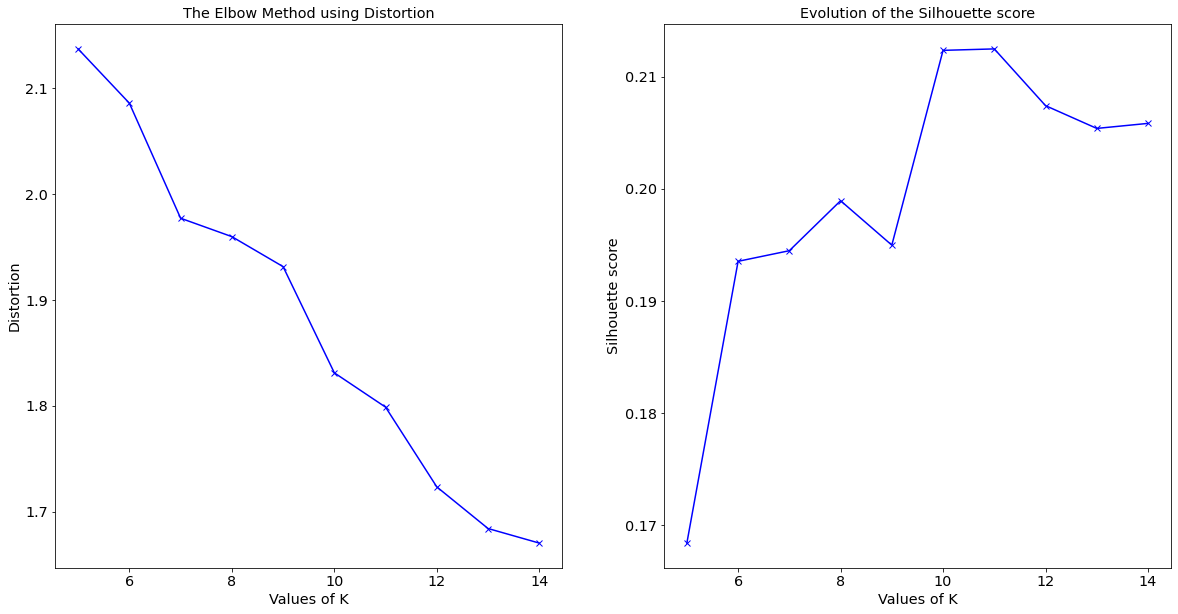

In [27]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(numbers_of_clusters, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.subplot(1,2,2)
plt.plot(numbers_of_clusters, silhouette, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Evolution of the Silhouette score') 
plt.show() 
        

Data suggest that we have 11 clusters of customers. While shoulder is not very visible, the Silhouette score is highes at 11. This is stable between the different trials.

In [28]:
n_clusters = 11
# clusters = all_clusters[n_clusters]
# pickle.dump( clusters, open( "customer_categories.pkl", "wb" ) )

In [29]:
# If I redo training, result doesn't change except for the order of categories. 
# I use stored training to keep them fixed.
clusters = pickle.load( open( "customer_categories.pkl", "rb" ) )

In [30]:
customer_data['Category']=clusters

In [31]:
# customer_data.to_hdf("categorised_customers.hdf",key="df")

In [32]:
customer_data = pd.read_hdf("categorised_customers.hdf")

### Analysing clusters

First, let's see if I managed to separate clusters. I can look at t-distributed Stochastic Neighbor Embedding. This is a nice visual tool to see if the data is properly clustered.

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

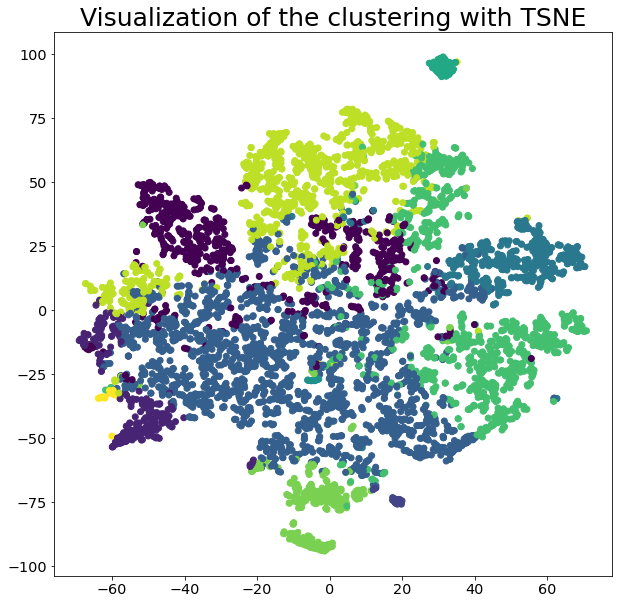

In [33]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(to_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")


The stand-alone clusters well-separated. Let's see Silhouette profiles.

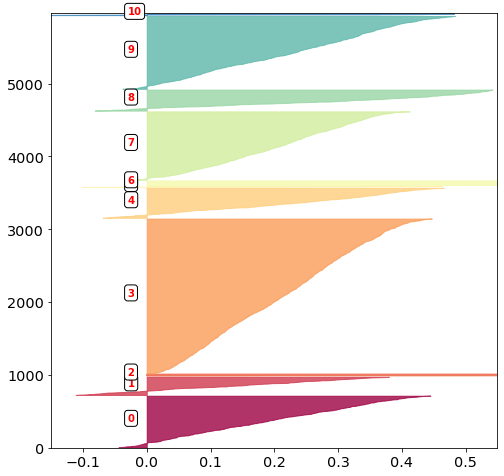

In [34]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  



silhouette_values = silhouette_samples(X, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(X), silhouette_values, clusters)




In [35]:
customer_data

,Amount,Quantity,Product_0,Product_1,Product_2,Product_3,Product_4,Country,Region,Frequency,...,Pending_Time,Average_Cheque,Average_Price,MaxInterval,MaxPending,r_quartile,f_quartile,m_quartile,RFM,Category
cID,,,,,,,,,,,,,,,,,,,,,
12346.0,169.36,24.0,0.000000,0.000000,0.000000,1.000000,0.000000,United Kingdom,0,2,...,4.483051,84.680000,6.450000,118.0,1.056523,4,3,4,434,8
12347.0,5633.32,3286.0,0.083384,0.293974,0.480219,0.136945,0.005478,Iceland,1,8,...,0.034826,704.165000,1.676006,90.0,1.232877,1,1,1,111,3
12348.0,1658.40,2704.0,0.576923,0.189349,0.233728,0.000000,0.000000,Finland,1,5,...,0.826446,331.680000,0.780028,173.0,1.429752,2,2,2,222,9
12349.0,3678.69,1621.0,0.154226,0.140654,0.543492,0.143122,0.018507,Italy,1,3,...,0.063047,1226.230000,2.265911,389.0,1.629552,1,3,1,131,4
12350.0,294.40,196.0,0.000000,0.234694,0.765306,0.000000,0.000000,Norway,1,1,...,2.775611,294.400000,1.502041,NaN,NaN,3,4,4,344,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283.0,2730.70,1731.0,0.079723,0.271519,0.609474,0.036973,0.002311,United Kingdom,0,19,...,0.082443,143.721053,1.725329,144.0,1.591160,1,1,1,111,3
18284.0,411.68,493.0,0.565923,0.243408,0.158215,0.032454,0.000000,United Kingdom,0,1,...,3.858995,411.680000,0.835051,NaN,NaN,4,4,3,443,9
18285.0,377.00,144.0,0.000000,0.166667,0.722222,0.097222,0.013889,United Kingdom,0,1,...,5.909366,377.000000,2.618056,NaN,NaN,4,4,3,443,3


The clusters are reasonably isolated. Let's proceed with the group characterisation.

In [36]:
# I combine the customer data per group and see if I can notice the reason for such groups by eye.
cat_analysis = customer_data[['Average_Cheque','Amount','Quantity','Average_Interval','Frequency','Recency_Min','Recency_Max','r_quartile','f_quartile','m_quartile','Category','Region']].groupby("Category").mean()
cat_analysis['Total amount'] = customer_data[['Amount','Category']].groupby("Category").sum()
cat_analysis['Counts'] = customer_data.reset_index()[['cID','Category']].groupby("Category").count()
cat_analysis = cat_analysis.round(1)
cat_analysis.sort_values("Total amount", ascending = False)

,Average_Cheque,Amount,Quantity,Average_Interval,Frequency,Recency_Min,Recency_Max,r_quartile,f_quartile,m_quartile,Region,Total amount,Counts
Category,,,,,,,,,,,,,
1,575.4,22672.9,13549.9,23.6,36.8,23.9,690.9,1.2,1.0,1.0,0.1,5645551.4,249
3,384.9,2448.1,1285.5,98.0,5.8,243.5,600.7,2.7,2.2,2.2,0.1,5202270.6,2125
10,7565.9,95568.0,62515.0,77.4,14.1,237.6,448.2,2.4,2.7,1.0,0.8,1911359.8,20
9,324.4,1530.5,1600.3,98.8,4.2,192.7,425.1,2.5,2.7,2.6,0.1,1533562.0,1002
7,371.4,945.6,491.6,80.5,2.5,91.8,157.7,2.0,3.2,2.9,0.1,886948.9,938
0,320.4,1141.5,813.8,107.4,3.4,267.6,464.2,2.9,3.0,2.8,0.1,805912.0,706
4,375.5,874.7,535.2,353.0,2.3,123.8,565.8,2.2,2.9,2.8,0.1,361234.9,413
8,303.4,1220.1,303.9,106.8,3.3,302.0,453.8,3.0,3.2,3.1,0.0,352598.2,289
6,744.5,2098.9,1271.1,114.4,2.5,288.8,437.4,3.0,3.2,2.4,10.0,140628.4,67


In [37]:
# Here goes some technical auxilary fiunctions.
# In this cell I create a script that automatically characterise each category, 
# and returns relevant values that I use for plottings later on

def plot_basket(b,c):
    plt.figure()
    plt.hist(b,bins = 20)
    plt.title("Distribution of average basket sizes in category "+str(c))
    plt.show()
    return

def plot_profile(p,c):
    plt.figure()
    ind = range(len(p))
    plt.bar(ind, p)
    plt.xticks(ind, ["Basket "+str(i+1) for i in ind])
    plt.title("Shopping profile of category "+str(c))
    plt.yticks([])
    plt.show()
    return 

def plot_freq(f,c):
    plt.figure()
    plt.hist(f,bins = 20)
    plt.title("Distribution of number of buys in category "+str(c))
    plt.show()
    return


def rfm_plot(df):
    # This function plots distribution of the customers of given caegory within RFM quantiles
    max_rfm = df[['cID','r_quartile','m_quartile','f_quartile']].groupby(['r_quartile','m_quartile','f_quartile']).count().reset_index()['cID'].max()
    plt.figure()
    for q in range(1,5):
        plt.subplot(2, 2, q)
        mx = df.query("r_quartile == "+str(q)).groupby(["f_quartile","m_quartile"])['cID'].count().unstack().to_numpy()
        plt.imshow(mx,vmin = 0, vmax = max_rfm)
        plt.colorbar()
        plt.xlabel("Frequency quartiles")
        plt.xticks(range(4),[1,2,3,4])
        plt.ylabel("Monetary quartiles")
        plt.yticks(range(4),[1,2,3,4])
        plt.title(str(q)+" recency quartile")

def describe_category(c):
    # We need to describe many categories, so let's prepare the script that would give us the summery.
    # This is what we want to know about the category:
    # - Where do the customers come from?
    # - How much money do they bring?
    # - What do they buy?
    # - How regularly do they buy? 
    # Let's answer these questions one by one
    
    print('*'*20)
    print("Customers from category",c)
    df = customer_data[customer_data.Category == c]
    
    # Where do the customres come from?
    print('*'*10)
    print("Countries")
    countries = df['Country'].value_counts()
    regions = {}
    print(countries)
    for country in countries.index:  
        v = countries[country]
        r = known_world[country]
        if r in regions.keys():
            regions[r]+=v
        else:
            regions[r] = v
    print('-'*10)        
    print("Regions")
    pprint(regions)
    print('*'*10)       
    
    # How much money do they bring?
    print('*'*10)
    print("All customers brought",int(df['Amount'].sum()))
    print("In average, single customer bring",int(df['Amount'].mean()))
    print("The basket size varies within [",int(df['Average_Cheque'].min()+0.5),";",\
          int(df['Average_Cheque'].max()+0.5),'] with mean at',int(df['Average_Cheque'].mean()))
    basket_size = list(df['Average_Cheque'].values)
    amount = list(df['Amount'].values)
    print('*'*10)
    
    # What do they buy?
    # See plot below
    print('*'*10)
    profile = df[product_categories+['Category']].groupby("Category").mean().loc[:,product_categories].values[0]
    prices = list(df['Average_Price'].values)
    print("Most often they buy products from category",np.argmax(profile)+1)
    
    # How regularly do they buy?
    print("They have ",int(df['Frequency'].min()+0.5)," to ",\
          int(df['Frequency'].max()+0.5),' buys with mean at',int(df['Frequency'].mean()))
    print("The recency is between",int(df['Recency_Min'].min()+0.5)," and ",\
          int(df['Recency_Min'].max()+0.5),' days with mean at',int(df['Recency_Min'].mean()))
    
    
    frequency = list(df['Frequency'].values)
    last_buy = list(df['Recency_Min'].values)
    print('*'*20)
    
    # Actually, I don't need these plots anymore since I merge them in box plots later.
    # plot_basket(basket_size, c)
    # plot_profile(profile, c)
    # plot_freq(frequency,c)
    
    rfm_plot(df.reset_index())
    
    return basket_size, profile, frequency, last_buy, amount, prices


********************
Customers from category 0
**********
Countries
United Kingdom     628
France              17
Germany             16
Spain                8
Sweden               7
Italy                6
Belgium              6
Netherlands          5
Channel Islands      3
Norway               2
Portugal             2
Austria              2
Unspecified          1
Finland              1
Switzerland          1
Czech Republic       1
Name: Country, dtype: int64
----------
Regions
{'Europe': 77, 'UK': 629}
**********
**********
All customers brought 805911
In average, single customer bring 1141
The basket size varies within [ 11 ; 1993 ] with mean at 320
**********
**********
Most often they buy products from category 2
They have  1  to  22  buys with mean at 3
The recency is between 0  and  738  days with mean at 267
********************
********************
Customers from category 1
**********
Countries
United Kingdom    227
Germany            10
France              6
Belgium           

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


********************
Customers from category 4
**********
Countries
United Kingdom     387
Germany              7
Portugal             4
Italy                3
Spain                3
Switzerland          2
Austria              2
Channel Islands      2
France               1
Malta                1
Sweden               1
Name: Country, dtype: int64
----------
Regions
{'Europe': 26, 'UK': 387}
**********
**********
All customers brought 361234
In average, single customer bring 874
The basket size varies within [ 4 ; 2708 ] with mean at 375
**********
**********
Most often they buy products from category 3
They have  2  to  4  buys with mean at 2
The recency is between 1  and  512  days with mean at 123
********************
********************
Customers from category 5
**********
Countries
United Kingdom    14
Name: Country, dtype: int64
----------
Regions
{'UK': 14}
**********
**********
All customers brought 10644
In average, single customer bring 760
The basket size varies within [ 43 

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


********************
Customers from category 6
**********
Countries
Australia               13
Japan                   10
Cyprus                   9
USA                      8
Canada                   5
Israel                   4
United Arab Emirates     4
Korea                    2
Bahrain                  2
RSA                      2
Brazil                   2
West Indies              1
Thailand                 1
Nigeria                  1
Singapore                1
Lebanon                  1
Saudi Arabia             1
Name: Country, dtype: int64
----------
Regions
{'Africa': 3,
 'Asia': 35,
 'North America': 13,
 'Oceania': 13,
 'South America': 3}
**********
**********
All customers brought 140628
In average, single customer bring 2098
The basket size varies within [ 52 ; 4874 ] with mean at 744
**********
**********
Most often they buy products from category 3
They have  1  to  12  buys with mean at 2
The recency is between 4  and  729  days with mean at 288
********************
*

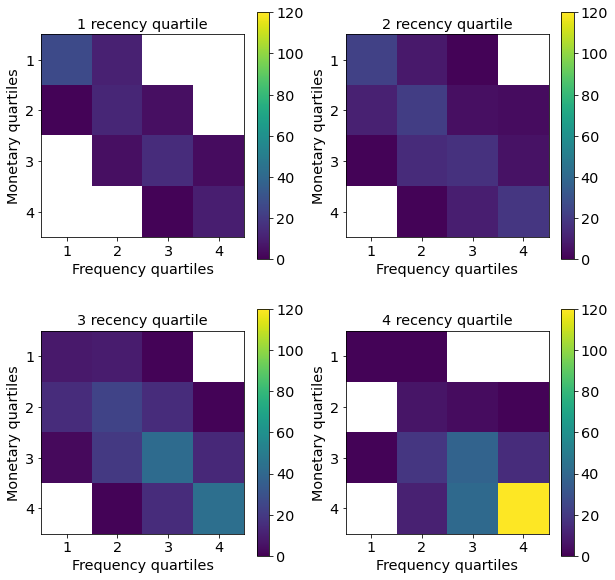

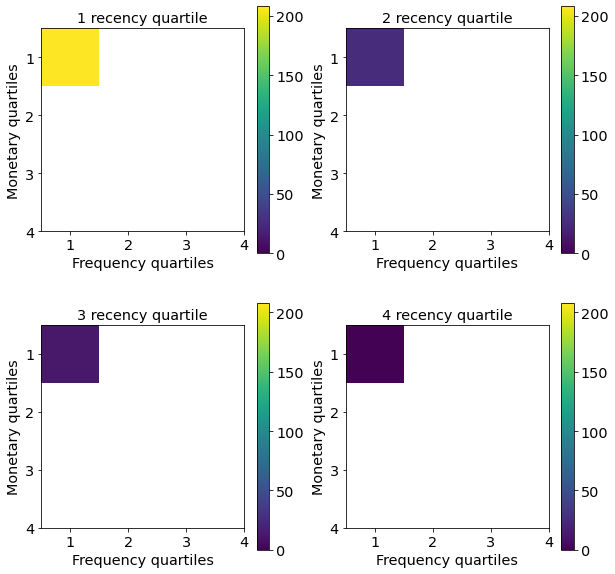

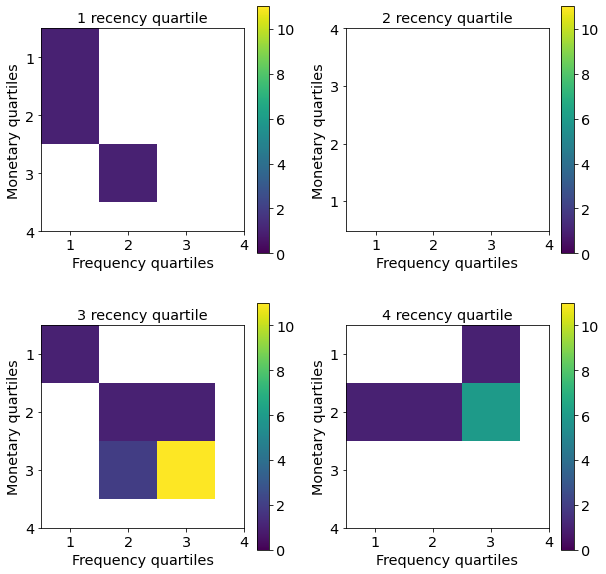

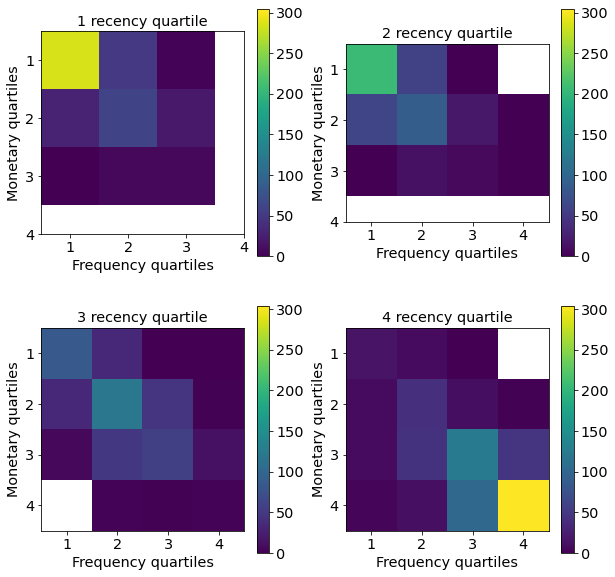

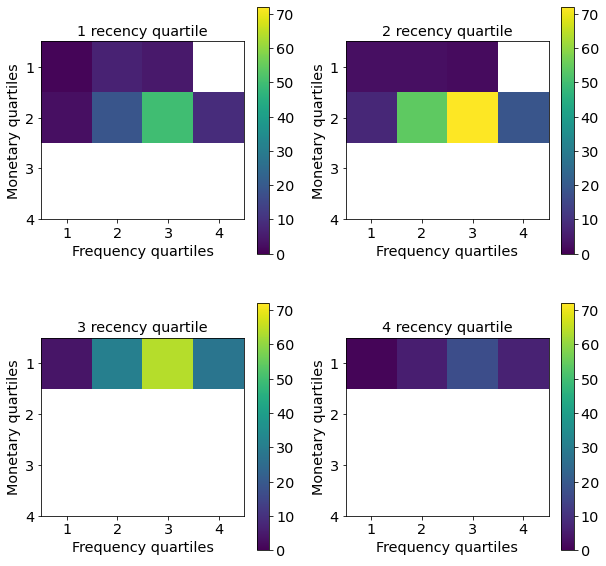

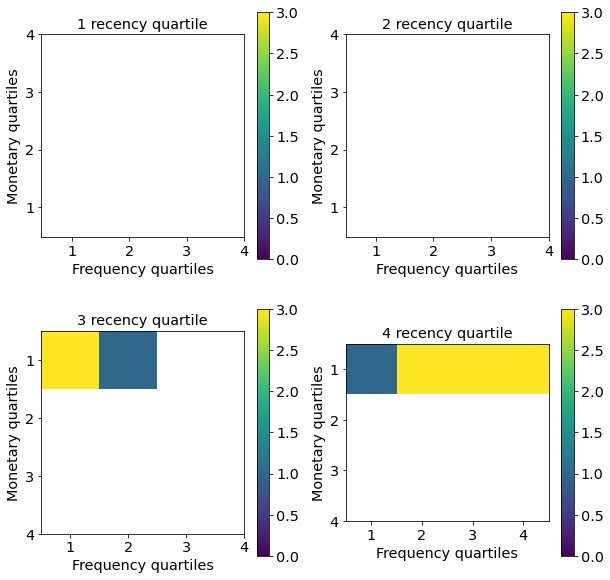

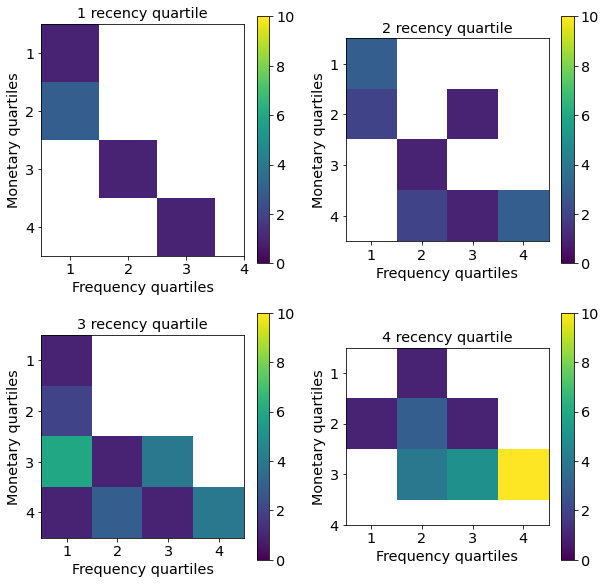

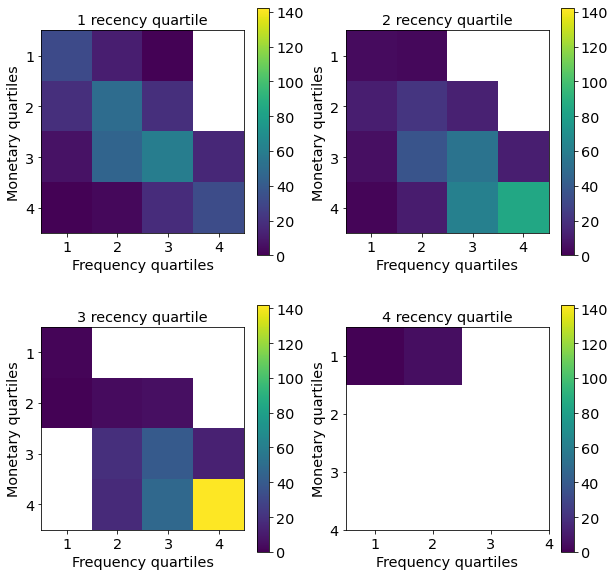

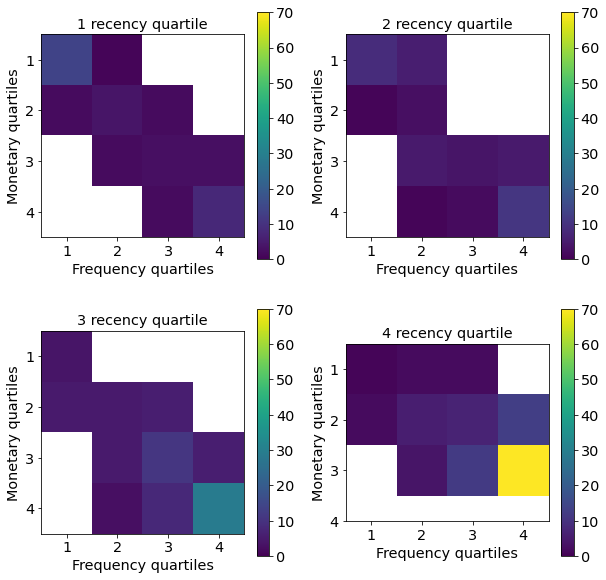

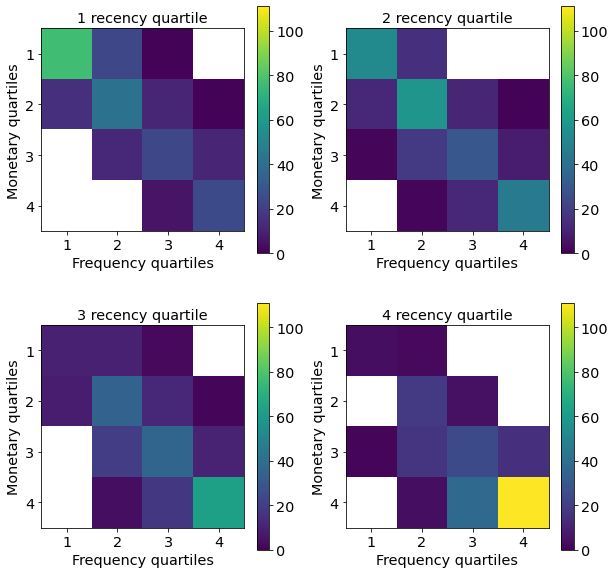

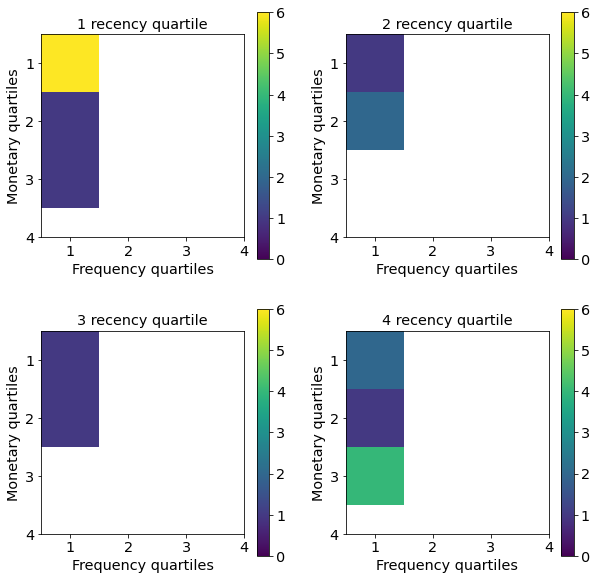

In [38]:
basket_sizes = {}
profiles = {}
frequencies = {}
lastbuys = {}
amounts = {}
prices = {}
# Here I run my scripts to characterise each cluster, one by one
for c in range(n_clusters):
    basket_sizes[c],profiles[c],frequencies[c],lastbuys[c], amounts[c], prices[c] = describe_category(c)

Below I make several self-explainatory plots.

Text(0.5, 1.0, 'Average basket sizes per category')

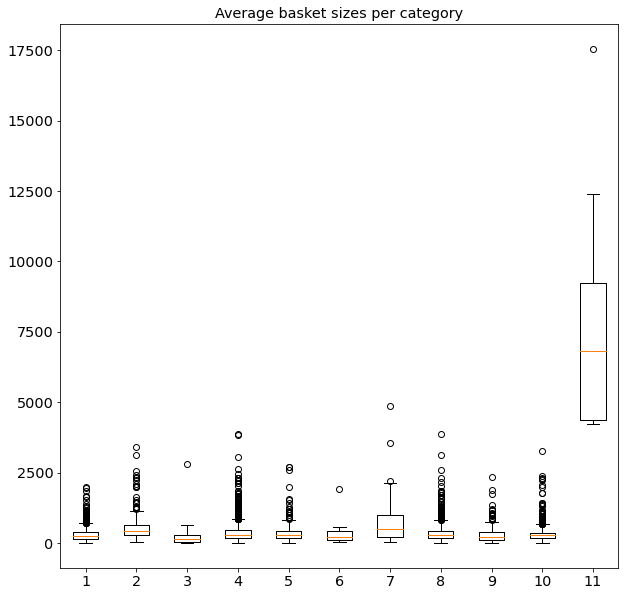

In [39]:
plt.subplots()
p = plt.boxplot(basket_sizes.values())
plt.title("Average basket sizes per category")
# plt.xticklabels(basket_sizes.keys())

Category 11 seems to spend a lot!

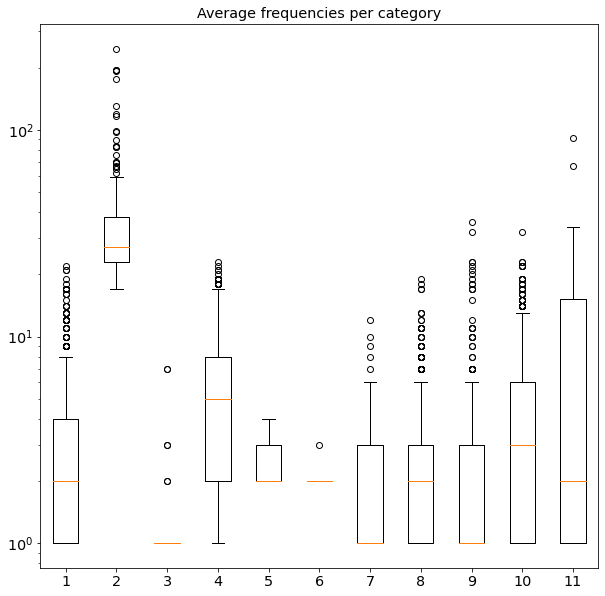

In [40]:
plt.subplots()
p = plt.boxplot(frequencies.values())
plt.title("Average frequencies per category")
plt.yscale("Log")
# plt.xticklabels(basket_sizes.keys())

Category 2 are the frequent buyers.

Text(0.5, 1.0, 'Average recencies per category')

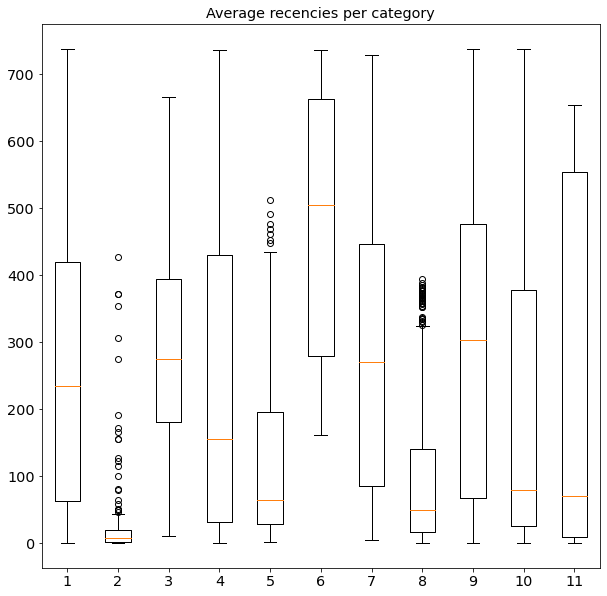

In [41]:
plt.subplots()
p = plt.boxplot(lastbuys.values())
plt.title("Average recencies per category")
# plt.xticklabels(basket_sizes.keys())

Customers from category didn't shop for more than a year, in average. They are probably lost.

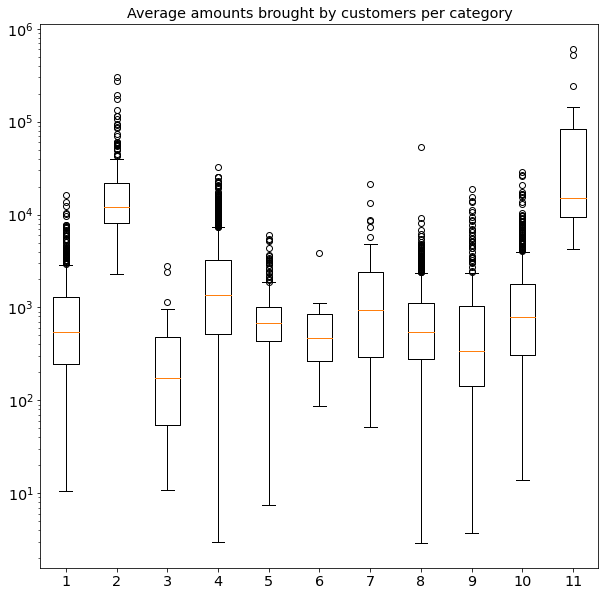

In [42]:
plt.subplots()
p = plt.boxplot(amounts.values())
plt.title("Average amounts brought by customers per category")
plt.yscale("Log")
# plt.xticklabels(basket_sizes.keys())

The most important categories for business  are 2 and 11 (note the log scale)

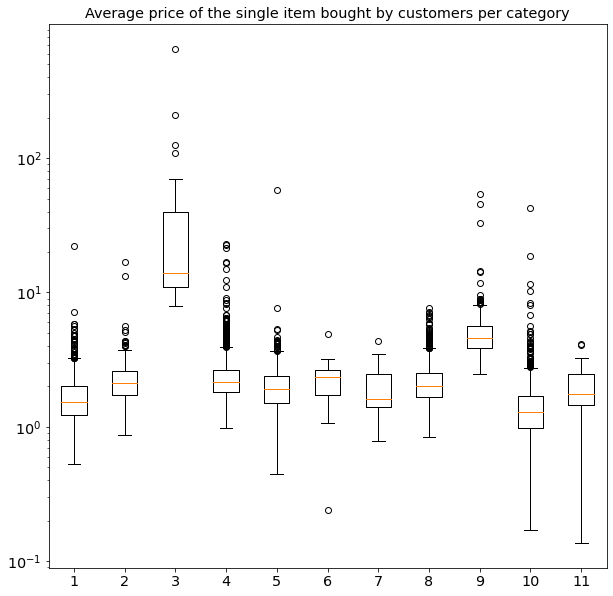

In [43]:
plt.subplots()
p = plt.boxplot(prices.values())
plt.title("Average price of the single item bought by customers per category")
plt.yscale("Log")
# plt.xticklabels(basket_sizes.keys())

People from category 3 buy the most expensive items!

## Groups summary
### Group 1:  "Cheap" customers
These clients have very few item in the basket when they shop and also the lowes average cheque. Probably they are normal people buying goods for themselves. Their impact on the company's income is small.
### Group 2: Core clients
This group cosists of 52 loyal and frequently-buying customers. Cusomers in this do buy frequently and has the most recent buys in the dataset. Each customer from this category have brought the most money to the company compared to other categories. The company could offer them loyality cards and target new products. The customers are mostly from UK and nearest European countries.
### Group 3: People buying expensive gifts
Clients from this group populate low FM quantiles, they buy not very often and not alot. However, when they buy, they buy rather expensive items! My guess would be the normal people buying expensive items.
### Group 4: Risk of  loosing
This is the lagrest group of more than 2000 customers responsible for almost the half of the money received by the company. Clients from this group used to buy rather frequenctly and with good average cheque, but many of them did not buy for quite some time already.
### Group 5: Festivity buyers
Clients from this category make orders once a year. 
### Group 6: Lost occasional clients
These clients from UK didn't buy anything for almost two years and can be considered lost. However, all clients in this group did just few buys within few days. 
### Group 7: Customers from far away
This group contains customers from everywhere but UK and Europe. They are few, but the have quite high basket size.
### Group 8: New customers
These clients populate low FM quantiles, but this is because they are new. With time, they can evolve to the loyal customers!
### Group 9: Usual people
Behaviour of these clients is similar to those from group 1, though they buy a little more frequent. 

### Group 10: Low profile
This is a big group of notmal customers who make a deal in average every three months. They are responsible for 8% of the money received by the company
### Group 11: Big spenders
These are the big spenders with the highest average bill. Probably they are big partners of the company from UK, Switzerland, Germany, Denamrk, and Australia. However, they seem to stop buying the products. May be company could bring them back with targetes marketing campaign. 








In [44]:
cat_analysis

,Average_Cheque,Amount,Quantity,Average_Interval,Frequency,Recency_Min,Recency_Max,r_quartile,f_quartile,m_quartile,Region,Total amount,Counts
Category,,,,,,,,,,,,,
0,320.4,1141.5,813.8,107.4,3.4,267.6,464.2,2.9,3.0,2.8,0.1,805912.0,706
1,575.4,22672.9,13549.9,23.6,36.8,23.9,690.9,1.2,1.0,1.0,0.1,5645551.4,249
2,284.1,439.6,31.2,111.0,1.6,297.0,344.1,3.1,3.6,3.5,0.1,12308.8,28
3,384.9,2448.1,1285.5,98.0,5.8,243.5,600.7,2.7,2.2,2.2,0.1,5202270.6,2125
4,375.5,874.7,535.2,353.0,2.3,123.8,565.8,2.2,2.9,2.8,0.1,361234.9,413
5,375.5,760.3,427.6,1.8,2.1,473.5,475.4,3.7,3.0,2.9,0.0,10644.6,14
6,744.5,2098.9,1271.1,114.4,2.5,288.8,437.4,3.0,3.2,2.4,10.0,140628.4,67
7,371.4,945.6,491.6,80.5,2.5,91.8,157.7,2.0,3.2,2.9,0.1,886948.9,938
8,303.4,1220.1,303.9,106.8,3.3,302.0,453.8,3.0,3.2,3.1,0.0,352598.2,289


# Churning of the customers

There is no clear signal of churning for the individual customer. Howerer, having the history of customer's acquisitions, it's possible to suggest a metrics that would allow to measure "risk of churning". In lines above we defined `Pending` variable that corresponds to the time passed from the last buy normalised to the average time between buys for the customer (we used average among the all customers fro those who had just one buy).


Moreover, we have calculated for each customer ther `MaxPending` time, which is the highest pending value in between buys (i.e. when the customer is certainly not churned). Let's compare them with current pending vaules.

/Users/ilya/Env_For_All/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ilya/Env_For_All/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Pending time ')

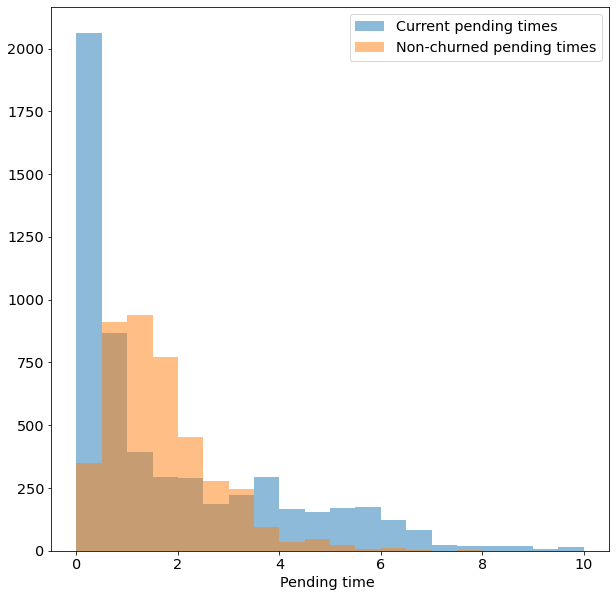

In [45]:
plt.hist(customer_data['Pending_Time'], range = [0, 10], bins = 20, label = "Current pending times", alpha = 0.5)
plt.hist(customer_data['MaxPending'], range = [0, 10], bins = 20, label = "Non-churned pending times", alpha = 0.5)
plt.legend()
plt.xlabel("Pending time ")

In [46]:
customer_data['MaxPending'].quantile([.50, .68,.90])

0.50    1.441527
0.68    1.891922
0.90    3.115982
Name: MaxPending, dtype: float64

We see that maximal pending time for 90% of customers is less than 3. Hereby, we can say that customer with pending time within the interval [3, 6] are in the high ristk of churning, and the customers with pending time more than 6 are churned.

Let's see what customers churned in the first half of 2011:

In [47]:
mid_2011 = pd.datetime(2011, 7, 1).date()
end_2010 = pd.datetime(2011, 1, 1).date()

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [48]:
customer_data["Pending_Time_Mid11"] = (customer_data["Recency_Min"]-(last_day - mid_2011).days)/customer_data["Average_Interval"]
customer_data["Pending_Time_End10"] = (customer_data["Recency_Min"]-(last_day - end_2010).days)/customer_data["Average_Interval"]

In [49]:
# How many customers churned in early 2011?
customer_data.query("Pending_Time_Mid11 > 6 and Pending_Time_End10 <= 6").shape[0]

166

In [50]:
# How many of theme were from the highest FM quartiles?
customer_data.query("Pending_Time_Mid11 > 6 and Pending_Time_End10 <= 6 \
                     and m_quartile == 1 and f_quartile == 1").shape[0]

22

In [51]:
# How many customers churned in the second half of 2011?
customer_data.query("Pending_Time > 6 and Pending_Time_Mid11 <= 6").shape[0]

323

In [53]:
# # How many of theme were from the highest FM quartiles?
# churned_late_2011.query('Pending_Time > 6 and Pending_Time_Mid11 <= 6 and \
#                         m_quartile == 1 and f_quartile == 1').shape[0]

NameError: name 'churned_late_2011' is not defined

In [151]:
# How many customers are in risk of churning?
customer_data.query("6 >= Pending_Time > 4").shape[0]

664

In [152]:
# How many of good customers are in risk of churning?
customer_data.query("6 >= Pending_Time > 4 and m_quartile == 1 and f_quartile == 1").shape[0]

28

As we can see from these results, In early 2011 the company has lost 166 customers, of them 25 from the highest monetary and frequency quartiles.
In the second half of 2011, the company has already lost 323 customers, of them 19 are from the the highest monetary and frequency quartiles.
By now, 664 customers are in risk of churning, of them 28 are from the the highest monetary and frequency quartiles.

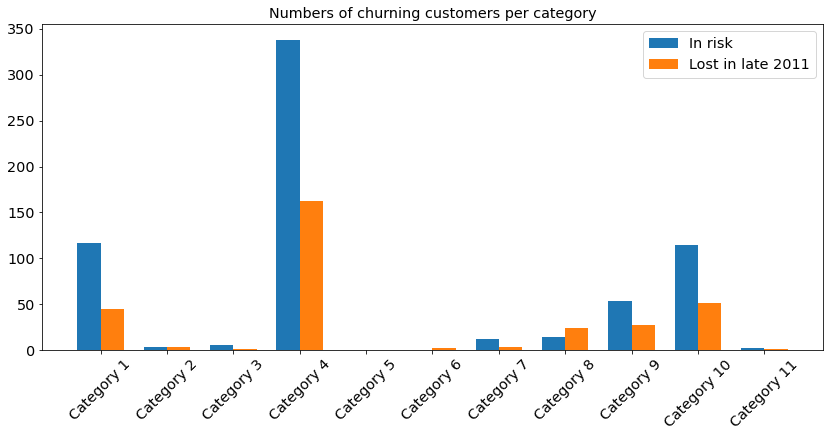

In [153]:
risky_distr = customer_data.reset_index()[['Category','cID']].groupby("Category").count()
risky_distr['In_Risk'] = customer_data.reset_index().query("6 >= Pending_Time > 4")[['cID','Category']].groupby("Category").count()
risky_distr['Lost_Late_2011'] = customer_data.reset_index().query("Pending_Time > 6 and Pending_Time_Mid11 <= 6")[['cID','Category']].groupby("Category").count()
risky_distr = risky_distr.fillna(0)

import numpy as np
plt.figure(figsize=(14,6))
plt.xticks(rotation=45) 

plt.title("Numbers of churning customers per category")
width = 0.35
plt.bar(np.arange(risky_distr.shape[0])-width/2, risky_distr['In_Risk'], width, label = "In risk")
plt.bar(np.arange(risky_distr.shape[0])+width/2, risky_distr['Lost_Late_2011'], width, label = "Lost in late 2011")
plt.xticks(range(risky_distr.shape[0]),['Category '+str(i+1) for i in range(risky_distr.shape[0])])
# plt.yscale('log')
plt.legend()



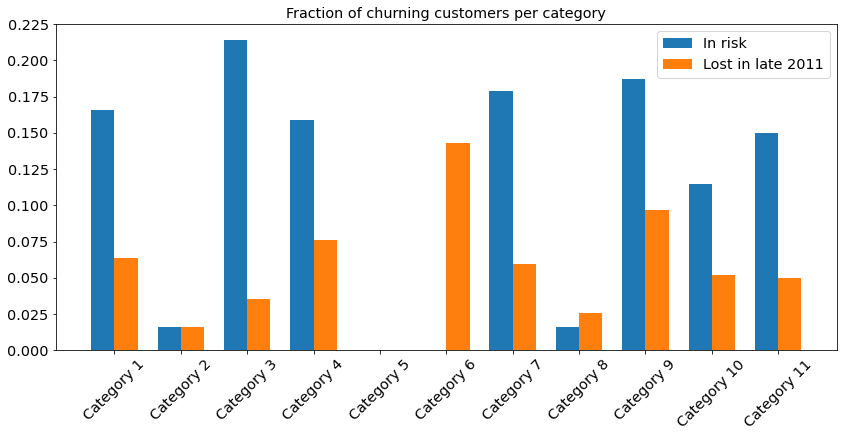

In [155]:
risky_distr = customer_data.reset_index()[['Category','cID']].groupby("Category").count()
risky_distr['In_Risk'] = customer_data.reset_index().query("6 >= Pending_Time > 4")[['cID','Category']].groupby("Category").count()/customer_data.reset_index()[['cID','Category']].groupby("Category").count()
risky_distr['Lost_Late_2011'] = customer_data.reset_index().query("Pending_Time > 6 and Pending_Time_Mid11 <= 6")[['cID','Category']].groupby("Category").count()/customer_data.reset_index()[['cID','Category']].groupby("Category").count()
risky_distr = risky_distr.fillna(0)

import numpy as np
plt.figure(figsize=(14,6))
plt.xticks(rotation=45) 

plt.title("Fraction of churning customers per category")
width = 0.35
plt.bar(np.arange(risky_distr.shape[0])-width/2, risky_distr['In_Risk'], width, label = "In risk")
plt.bar(np.arange(risky_distr.shape[0])+width/2, risky_distr['Lost_Late_2011'], width, label = "Lost in late 2011")
plt.xticks(range(risky_distr.shape[0]),['Category '+str(i+1) for i in range(risky_distr.shape[0])])
# plt.yscale('log')
plt.legend()



# Customer prediction

I have 11 groups of customers with two of them being the most imprtant for the business: loyal customers and big spenders. I want to understand if it's possible to see if the customer falls into one of such categories. While it's clear how to do so for the big spender (just check the basket size of the first purhcase), let's see where I can find out some way to select candidates for becaming "loyal customers" judjing on their first (and second) purchase.

I will use an assumption that purchasing pattern of the customer does not change with time. So, let's create sample of first purchases for customers from the "loyal customers" category and not.

In [54]:
loyal_customers = customer_data.reset_index().query("Category == 1")['cID']

In [56]:
lc_invoices = invoice_data[invoice_data.cID.isin(loyal_customers)]

In [57]:
nlc_invoices = invoice_data[~invoice_data.cID.isin(loyal_customers)]

In [58]:
lc_invoices['is_loyal'] = 1
nlc_invoices['is_loyal'] = 0
flagged_invoice_data = pd.concat([lc_invoices, nlc_invoices])

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now we have invoices from loyal and not loyal customers. Let's define metrics we will use for prediction:

In [60]:
from sklearn import neighbors, datasets, preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [61]:
prediction_metrics = ['Quantity','Amount','Region'] + product_categories

In [62]:
X, y = flagged_invoice_data[prediction_metrics],flagged_invoice_data.is_loyal
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=33)
scaler = preprocessing.QuantileTransformer(n_quantiles = 100).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

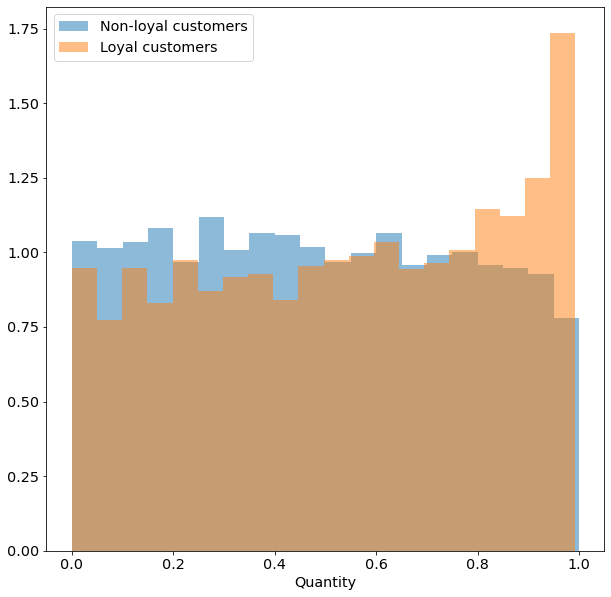

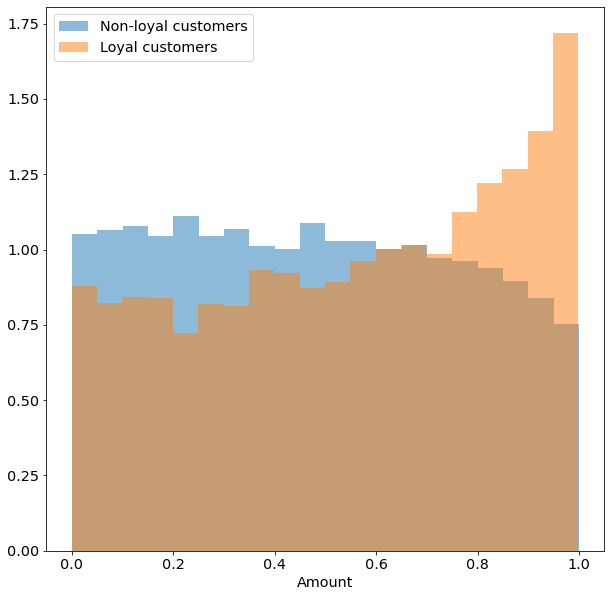

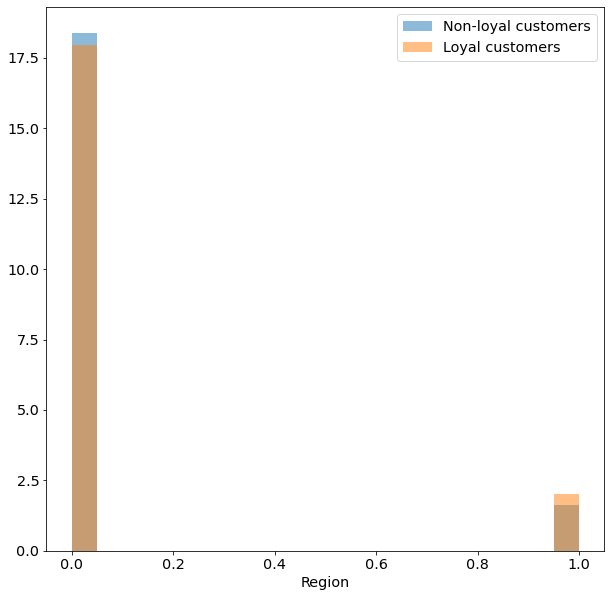

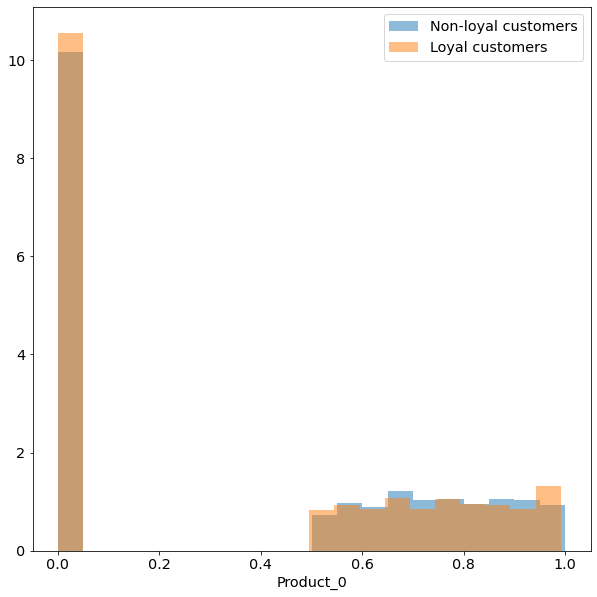

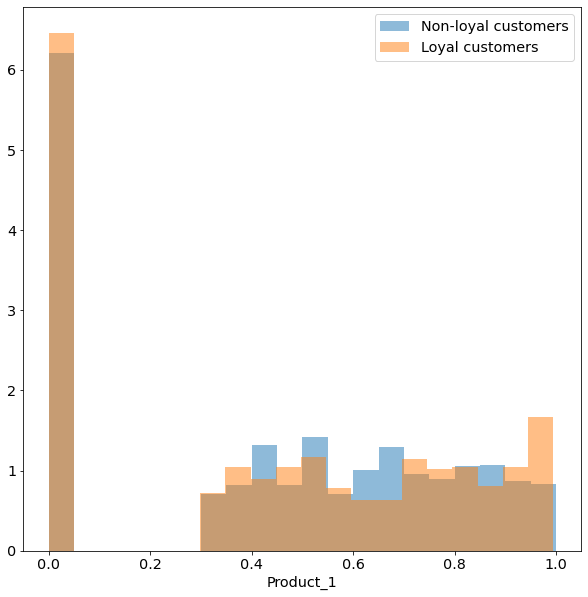

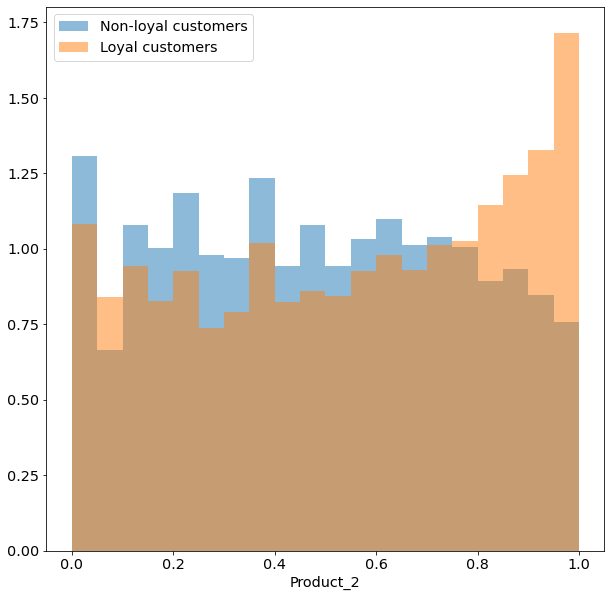

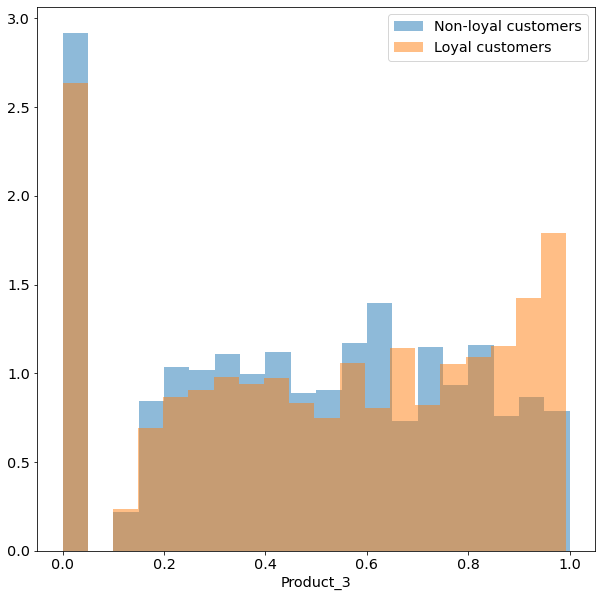

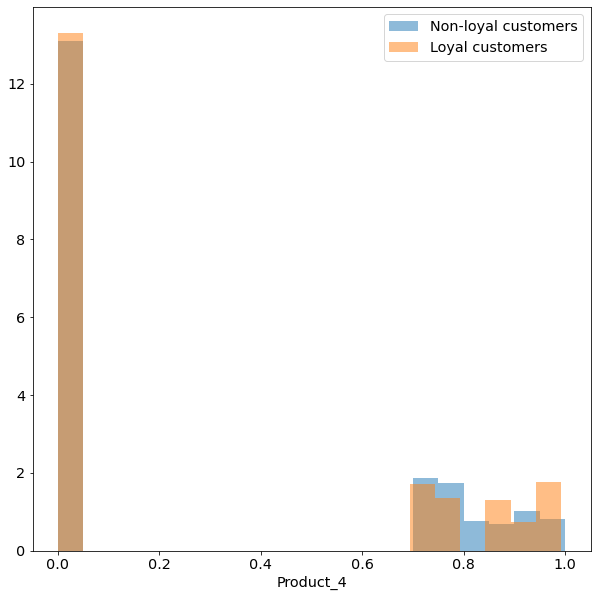

In [67]:
for i,p in enumerate(prediction_metrics):
    plt.figure()
    plt.hist(scaler.transform(nlc_invoices[prediction_metrics])[:,i], bins = 20, label = "Non-loyal customers", alpha = 0.5, density = True)
    plt.hist(scaler.transform(lc_invoices[prediction_metrics])[:,i], bins = 20, label = "Loyal customers", alpha = 0.5, density = True)    
    plt.xlabel(p)
    plt.legend()

We see that we have some variables to discriminate loyal and not loyal customers. Let's try to classify it with the basic BDT.

In [104]:
clf = svm.SVC()
y_pred = clf.fit(X_train, y_train).decision_function(X_test)
# y_pred = clf.predict(X_test)

In [105]:
roc_curve(y_test.values, y_pred)

(array([0.00000000e+00, 1.69033130e-04, 1.69033130e-04, ...,
        9.99830967e-01, 9.99830967e-01, 1.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 8.75273523e-04, ...,
        9.99562363e-01, 1.00000000e+00, 1.00000000e+00]),
 array([ 1.23696271,  0.23696271,  0.09608994, ..., -1.15929397,
        -1.17372724, -1.19946672]))

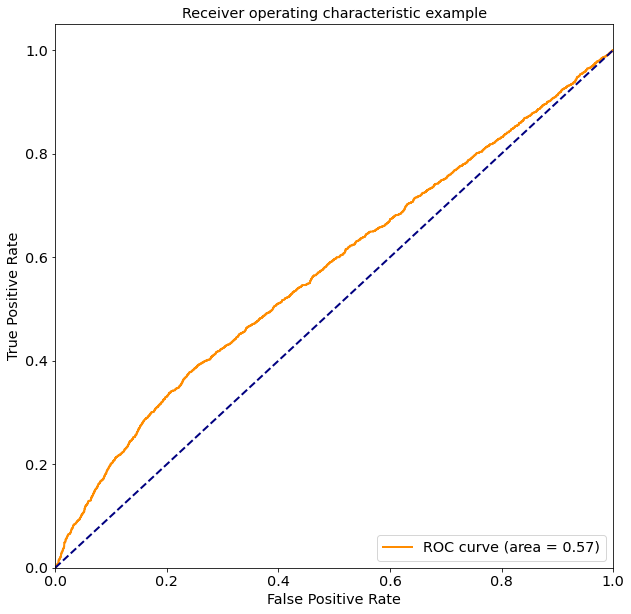

In [107]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

With this classifier we can presict if the customer will become loyal judging on their first purchase (slightly) better than random. Let's see if we can get anything better with the two purchases.

Let's combime "pair of invoices" data structure made from the two consequent invoices that would have the same infomration as before, but with extra info about the time difference of the two purchaces

In [110]:
multiple_customers =  customer_data.reset_index().query("Frequency > 1")['cID']

In [125]:
tmp_invoice_data = flagged_invoice_data[invoice_data.cID.isin(multiple_customers)]

two_invoice_data = tmp_invoice_data[['cID','Quantity','Amount'] + product_categories].groupby('cID').first()
two_invoice_data += tmp_invoice_data[['cID','Quantity','Amount'] + product_categories].groupby('cID').nth(1)

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [126]:
def get_interval(dates):
    if len(dates)<2:
        return np.nan
    dates = dates.values
    dates = sorted(dates)
    interval = dates[1]-dates[0]
    return interval.days

two_invoice_data['is_loyal'] = tmp_invoice_data[['cID','is_loyal']].groupby('cID').first()
two_invoice_data['Region'] = tmp_invoice_data[['cID','Region']].groupby('cID').first()
two_invoice_data['Interval'] = tmp_invoice_data[['cID','InvoiceDate']].groupby('cID').agg(get_interval)

In [136]:
prediction_metrics = ['Quantity','Amount','Region','Interval'] + product_categories

In [144]:
two_invoice_data

,Quantity,Amount,Product_0,Product_1,Product_2,Product_3,Product_4,is_loyal,Region,Interval
cID,,,,,,,,,,
12346.0,24.0,169.36,0.0,0.0,0.0,24.0,0.0,0,0,118
12347.0,1147.0,2035.11,122.0,274.0,566.0,182.0,3.0,0,1,37
12348.0,1620.0,873.96,984.0,468.0,168.0,0.0,0.0,0,1,80
12349.0,991.0,2221.14,200.0,144.0,489.0,137.0,21.0,0,1,182
12352.0,188.0,343.80,0.0,24.0,155.0,8.0,1.0,0,1,17
...,...,...,...,...,...,...,...,...,...,...
18281.0,146.0,201.14,72.0,10.0,54.0,8.0,2.0,0,0,397
18282.0,98.0,176.60,55.0,8.0,21.0,10.0,4.0,0,0,119
18283.0,84.0,210.07,1.0,15.0,54.0,11.0,3.0,0,0,11


In [140]:
X, y = two_invoice_data[prediction_metrics],two_invoice_data.is_loyal
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=33)
scaler_2 = preprocessing.QuantileTransformer(n_quantiles = 100).fit(X_train)
X_train = scaler_2.transform(X_train)
X_test = scaler_2.transform(X_test)

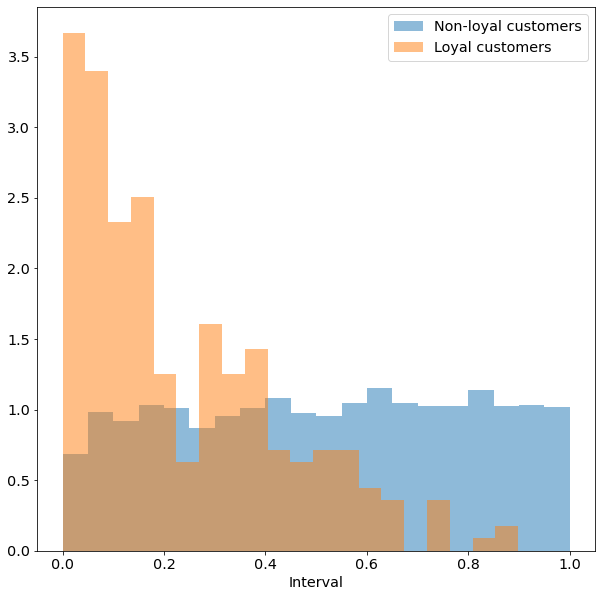

In [148]:
plt.figure()
plt.hist(scaler_2.transform(two_invoice_data.query("is_loyal == 0")[prediction_metrics])[:,3], bins = 20, label = "Non-loyal customers", alpha = 0.5, density = True)
plt.hist(scaler_2.transform(two_invoice_data.query("is_loyal == 1")[prediction_metrics])[:,3], bins = 20, label = "Loyal customers", alpha = 0.5, density = True)    
plt.xlabel('Interval')
plt.legend()

In [149]:
clf = svm.SVC()
y_pred = clf.fit(X_train, y_train).decision_function(X_test)


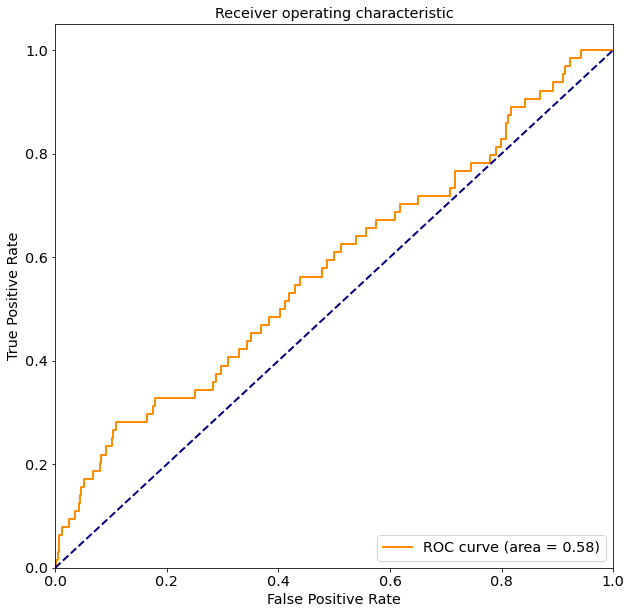

In [156]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

With this classifier we can predict if the customer will become loyal judging on their first two purchase (slightly) better than judging on one purchase. I could get better predicting power if I would work create better trainig dataset (by using all subsequent pairs of purcheses, and not just the firt pair)

## Life time value

To calculate lieftime value of the customer, we need to understand what would be expected churning time for them. Idealy, one would do it for the each group of customers, but for the sake of time I will do it for all customers.

First, let's find how much each customer brings money per half a year (in average). We divide the total money brought by the customer over the max recency and mutiply by the number of days in a half a year

In [177]:
old_customers = customer_data.query("Recency_Max > 182")

In [178]:
old_customers['Amount_half_year'] = old_customers['Amount']/old_customers['Recency_Max']*182                                                     

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Now, we claucalte a churn rate. Normaly, I would calculate it per cluster, but I'm short in time

In [179]:
churn_rate_in_half_year = customer_data.query("Pending_Time > 6 and Pending_Time_Mid11 <= 6").shape[0]/customer_data.query("Pending_Time_Mid11 <= 6").shape[0]
churn_rate_in_half_year

0.05769917827795641

So, company looses 6% of customers in half year, so average lifetime of a customer is ~8.7 years

In [180]:
1./churn_rate_in_half_year/2

8.6656346749226

Now, we can calcualte the lifetime value of the customers

In [181]:
old_customers['LTV'] = old_customers['Amount_half_year']/churn_rate_in_half_year

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


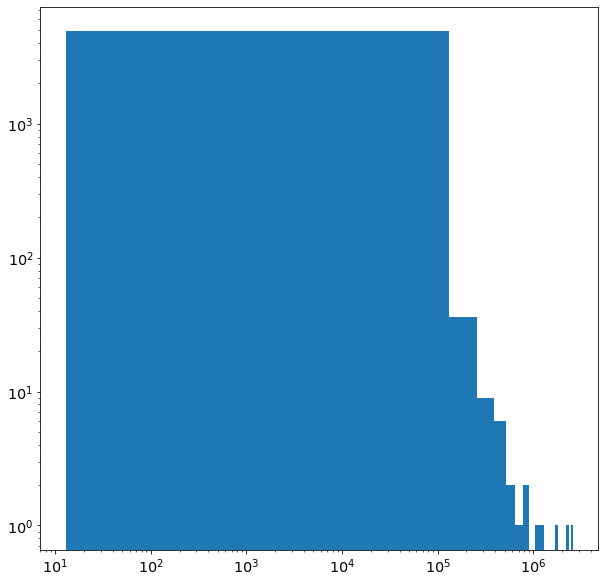

In [186]:
plt.hist(old_customers['LTV'], bins = 20)
plt.yscale('log')
plt.xscale('log')

So we have several very valuable customers, let's take a closer look at them:

In [187]:
old_customers.query("LTV > 1e6")

,Amount,Quantity,Product_0,Product_1,Product_2,Product_3,Product_4,Country,Region,Frequency,...,MaxPending,r_quartile,f_quartile,m_quartile,RFM,Category,Pending_Time_Mid11,Pending_Time_End10,Amount_half_year,LTV
cID,,,,,,,,,,,,,,,,,,,,,
14156.0,299123.08,164119.0,0.232161,0.139344,0.497420,0.116202,0.014873,EIRE,1,117,...,7.599022,1,1,1,111,1,-24.186557,-52.987654,73767.480434,1.278484e+06
14646.0,522225.25,364389.0,0.148783,0.208173,0.581842,0.057872,0.003329,Netherlands,1,91,...,3.502092,1,1,1,111,10,-19.565217,-41.698370,128962.002035,2.235075e+06
14911.0,272245.68,148883.0,0.209359,0.212066,0.443388,0.123137,0.012050,EIRE,1,247,...,5.301980,1,1,1,111,1,-53.405699,-113.820896,67139.178537,1.163607e+06
17450.0,240023.03,83686.0,0.007743,0.042875,0.508711,0.438401,0.002270,United Kingdom,0,31,...,1.748466,1,1,1,111,10,-10.674419,-23.302326,99735.596941,1.728544e+06
18102.0,607604.45,188008.0,0.004681,0.148371,0.367750,0.457183,0.022015,United Kingdom,0,67,...,5.819861,1,1,1,111,10,-14.398374,-30.585366,149842.831843,2.596966e+06


As expected, these customers are from the twon most important categories "Loayal customers" and "Big spenders"

## KPI for shop operations

There are several usual KPIs for sales. The good dashpoard should include few key inidcators, that would give exhaustive and comprehencive picture of business. I suggest to group KPIs in several logical groups approximately ordered by expected view frequency (i.e. more ofthen the group should be monitored, higher it is in the list):


 * Low-level alarms. Unexpected behavioud of these indicators can be a signal of serious issues
   * Total sales - the unexpected drop in this indicator is alarming sign that there are some troubles with the business.
   * Average order size - this indicator give an idea about the structure of customers 
   * Number of transactions: This is the total number of transactions. Use this KPI in conjunction with average  order size or total number of site visitors for deeper insights.   
   
   
 * Customers indicators. 
   * New customer orders vs. returning customer orders: This metric shows a comparison between new and repeat customers. Many business owners focus only on customer acquisition, but customer retention can also drive loyalty, word of mouth marketing, and higher order values.
   * Conversion rate: The conversion rate, also a percentage, is the rate at which users on your ecommerce site are converting (or buying). This is calculated by dividing the total number of visitors (to a site, page, category, or selection of pages) by the total number of conversions.
   * Shopping cart abandonment rate: The shopping cart abandonment rate tells you how many users are adding products to their shopping cart but not checking out. The lower this number, the better. If your cart abandonment rate is high, there may be too much friction in the checkout process.
   

 * Product indicators
   * Product affinity: This KPI tells you which products are purchased together. This can and should inform cross-promotion strategies.
   * Product relationship: This is which products are viewed consecutively. Again, use this KPI to formulate effective cross-selling tactics.   
   * Inventory levels: This KPI could tell you how much stock is on hand, how long product is sitting, how quickly product is selling, etc.  

 
 * Business opeations indicators. They can be used to optimise the business processes.   
   * Gross profit: Calculate this KPI by subtracting the total cost of goods sold from total sales.
   * Average margin: Average margin, or average profit margin, is a percentage that represents your profit margin over a period of time.   
   * Cost of goods sold (COGS): COGS tells you how much you’re spending to sell a product. This includes manufacturing, employee wages, and overhead costs.
   
   
 * Advanced business strategy. These can give important insight for revisiting of the business strategy
   * Customer lifetime value (CLV): The CLV tells you how much a customer is worth to your business over the course of their relationship with your brand. You want to increase this number over time through strengthening relationships and focusing on customer loyalty.    
   * Revenue per visitor (RPV): RPV gives you an average of how much a person spends during a single visit to your site. If this KPI is low, you can view website analytics to see how you can drive more online sales.
   * Churn rate: For an online retailer, the churn rate tells you how quickly customers are leaving your brand or canceling/failing to renew a subscription with your brand.
   * Customer acquisition cost (CAC): CAC tells you how much your company spends on acquiring a new customer. This is measured by looking at your marketing spend and how it breaks down per individual customer.
